## Simulating data for Gaussian response distributions

### Simulating a hidden sequence

In [121]:
import numpy as np

# Number of components 
k = 2
# Timesteps t
T = 100
# Set seed
np.random.seed(5637)
# Transition matrix
g = np.array([[0.3, 0.7],
              [0.6, 0.4]])
# Initial states
pi = np.array([0.8, 0.2])
# mu / sd of the states
mu = np.array([5,20])
sd = np.array([2,4])
# Draw from one of the states with probability pi_i
np.random.multinomial(1, pi)
# Generate sequence
seq = np.zeros((T, 1), dtype = np.int32)
for t in range(T):
    if t == 0:
        seq[t,:] = int(np.nonzero(np.random.multinomial(1, pi))[0])
    else:
        seq[t,:] = int(np.nonzero(np.random.multinomial(1, np.dot(pi, np.linalg.matrix_power(g, t))))[0])
        
# Squeeze output
seq = seq.squeeze()

### Simulating observed data 

In [122]:
# Allocate
obs = np.zeros(T, dtype = np.float32)
# Set seed
np.random.seed(88876)
# Populate
for i in range(T):
    # Get state
    state = seq[i]
    # Draw from normal distribution
    obs[i] = np.round(np.random.normal(mu[state], sd[state]), 4)

/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


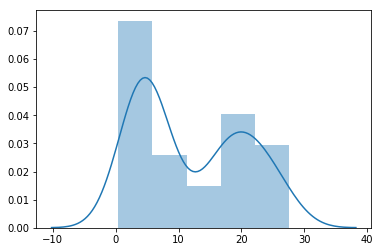

In [124]:
# Plot observed data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.distplot(obs)

## Estimating the state sequence

In [155]:
# Forward algorithm
from scipy.stats import norm

# We use the initial probabilities pi
# NOTE: we shouldn't really know these ...

# Initialize alpha using the initial distribution
alpha = pi
# Initialize states to 0
states = np.zeros(T, dtype = np.int32)
# For each observation and timestep t, compute the state using the forward algorithm
for t, x in enumerate(obs):
    # Compute probabilities for x at timestep t
    # Note that we are not assuming stationarity because we have alpha_1 = pi * P 
    #  at t == 1
    # Note that we are using population values mu and sd here
    p = norm.pdf(x, mu, sd)
    # Convert to diagonal matrix
    P = np.diag(p)
    # Form the matrix B
    B = np.dot(g, P)
    # Update alpha
    alpha = np.dot(alpha, B)
    # Add state
    states[t] = np.argmax(alpha)
    # At the last step, dot with 1' to get the likelihood
    if t == (T-1):
        L = np.dot(alpha, np.ones((k, 1), dtype = np.int32))

In [183]:
# Stack predicted and actual states column-wise
import pandas as pd
seqs = np.vstack((states,seq)).T
# Cast to data frame
print("First 10 observations ...")
pd.DataFrame(seqs, columns = ["predicted", "actual"]).head(10)

First 10 observations ...


,predicted,actual
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
5,0,0
6,0,0
7,1,1
8,0,0
9,1,1


In [189]:
# Print likelihood and alphas
print("Likelihood: {}".format(L))
print("Alphas at time T: {}".format(alpha))

Likelihood: [-318.9896569]
Alphas at time T: [7.07939551e-278 9.97743033e-281]


In the above implementation of the forward algorithm, clearly we are running into the issue of underflow. The values for the alphas are getting very small, and we need to start using some computational tricks to make sure we can handle longer sequences. See also chapt. 3.2 in Zucchini.

In [185]:
# Forward algorithm
from scipy.stats import norm

# Initialize alphas using the initial distribution
# scale the distribution by the sum of the alphas to prevent underflow
ones = np.ones((k, 1), dtype = np.int32)
phi = pi / np.dot(pi, ones) # ==> this is just scaling by 1 
# Initialize states to 0
states = np.zeros(T, dtype = np.int32)
# Initialize log-likelihood to 0
L = 0
# For each observation, compute the state using the forward algorithm
for t, x in enumerate(obs):
    # Compute probabilities for x at timestep t
    p = norm.pdf(x, mu, sd)
    # Convert to diagonal matrix
    P = np.diag(p)
    # Form the matrix B
    B = np.dot(g, P)
    # Create the vector v as the product of scaled alphas and B
    v = np.dot(phi, B)
    # Create the scalar u as the sum of the scaled alphas
    u = np.dot(v, ones)
    # Add to log-likelihood
    L += np.log(u)
    # Scale vector by the sum of v to create new phi
    phi = v / u
    # Add state
    states[t] = np.argmax(phi)

In [188]:
# Stack predicted and actual states column-wise
import pandas as pd
seqs = np.vstack((states,seq)).T
# Cast to data frame
print("First 10 observations ...")
pd.DataFrame(seqs, columns = ["predicted", "actual"]).head(10)

First 10 observations ...


,predicted,actual
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
5,0,0
6,0,0
7,1,1
8,0,0
9,1,1


In [194]:
# Print likelihood and alphas
print("Log-Likelihood: {}".format(L))
print("Phi at time T: {}".format(phi))

Log-Likelihood: [-318.9896569]
Phi at time T: [0.99859262 0.00140738]


### Dealing with constraints

For the normal HMM we have no real constraints on the parameters $\mu_1, \mu_2, \sigma^2_1, \sigma^2_2$ since they are continuous and can take on any value. However, we have a constraint on the transition probability matrix $\pmb{\Gamma}$ because its rows must sum to one.

In [278]:
def transform_tpm(gamma: np.array) -> dict:
    
    """
    Transform the transition probability matrix gamma using the function g(x) = exp(x)
    """
    
    # Apply transformation of gamma
    # NOTE: have to reshape this as a column vector to make it compatible with R implementation
    tgamma = np.log(g / np.diag(g).reshape((gamma.shape[0],1)))
    # Retrieve off-diagonal elements
    # NOTE: have to reverse the nonzero elements to make it compatible with R implementation
    idx_tau = np.nonzero(tgamma)[::-1]
    # Retrieve nonzero elements
    tgamma_flat = tgamma[idx_tau]
    # Return values of transformation and indices
    return({"tgamma": tgamma_flat, "tgamma_idx": idx_tau})

def transform_tgamma(tgamma: dict) -> np.array:
    
    """
    Transform the transformed values of gamma back to probabilities
    """
    
    # Get values from dict
    tgamma, tgamma_idx = tgamma.values()
    # Identity matrix
    z = np.eye(tgamma_idx[0].shape[0])
    # Fill off-diagonal elements
    z[tgamma_idx] = np.exp(tgamma)
    # Scale
    z /= np.sum(z, axis=1).reshape((z.shape[0], 1))
    # Return
    return(z)

### Starting values

To assign starting values for the parameters, we can do the following:

1. For means, we can divide the observations into $k$ subsets, 

The function below is a general, recursive function that can be used to compute the likelihood and state sequence.

In [ ]:
def HMM_forward(X: np.array, phi: np.array, gamma: np.array, k: int, **kwargs) -> tuple:
    
    """
    Use forward algorithm to compute the state sequence and Log-Likelihood
    
    :param X: Observed data
    :param phi: Initial distribution
    :param gamma: Transition Probability Matrix 
    :param k: Number of hidden states
    
    :return: tuple containing 
        (1) state sequence as T-dimensional array
        (2) Log-Likelihood
    """
    
    # Initialize alphas using the initial distribution
    # scale the distribution by the sum of the alphas to prevent underflow
    ones = np.ones((k, 1), dtype = np.int32)
    # If states not supplied, initialize them
    if kwargs.get("states") is None:
        # Initialize states to 0
        states = np.zeros(X.shape[0], dtype = np.int32)
    else:
        states = kwargs["states"]
    # Initialize log-likelihood to 0 if not passed
    if kwargs.get("L") is None:
        L = kwargs["L"]
    else:
        L = 0
        
    # ...
    pass